In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from models import MN_neuron_sp
import os
import numpy as np
import seaborn as sns
import glob
import json
from tbparse import SummaryReader
from pathlib import Path
sns.set_style("white")

In [4]:
def get_event_files(path):
    event_files = []
    for file in glob.iglob(path + "/**/events.out.tfevents*.0", recursive=True):
        print(file)
        event_files.append(file)
    return event_files

In [5]:
def extract_data_from_tensorboard(path):
    path_above = '/'.join(path.split('/')[:-1])
    reader = SummaryReader(path_above)
    df_scalar = reader.scalars
    df_hparam = reader.hparams
    if 'Braille' in path:
        name = 'braille'
    elif 'compressed' in path:
        name = 'mnist_compressed'
    elif 'mnist' in path:
        name = 'mnist'
    else:
        raise ValueError('No name found')
    
    # print(df_hparam)
    df_scalar['simulation'] = [name]*df_scalar.shape[0]
    # print(df_hparam)
    # print(path_above)
    seed_loc = df_hparam['tag'] == 'seed'
    
    if (name == 'braille') and (float(df_hparam.loc[df_hparam['tag'] == 'no_train_weights']['value']) == 1.0):
        # 
        # train_weight_loc = df_hparam['tag'] == 'no_train_weights'
        # # print(df_hparam.loc[train_weight_loc]['value'])
        # if float(df_hparam.loc[train_weight_loc]['value']) == 1.0:
            df_scalar['trained'] = [False]*df_scalar.shape[0]
    else:
        df_scalar['trained'] = [True]*df_scalar.shape[0]
    print(name,path_above.split('/')[-1],float(df_hparam.loc[seed_loc]['value']),df_scalar['trained'].unique(),df_scalar.shape[0])
    # print(df_hparam.loc[seed_loc])
    df_scalar['seed'] = [int(df_hparam.loc[seed_loc]['value'])]*df_scalar.shape[0]

    # for tag in df_scalar['tag'].unique():
    #     if len(df_scalar.loc[df_scalar['tag']==tag]['step']) != 300:
    #         print(name,int(df_hparam.loc[seed_loc]['value']),tag,len(df_scalar.loc[df_scalar['tag']==tag]['step']))
        
    # print([df_hparam.loc[seed_loc]['value']]*df_scalar.shape[0])
    df_hparam = pd.concat([df_hparam,pd.DataFrame({'tag':['name'],'value':[name]})], ignore_index=True)
    # df_hparam.loc[len(df_hparam.index)-1]['tag'] =  'name'
    # df_hparam.loc[len(df_hparam.index)-1]['value'] = name
    df_hparam = pd.concat([df_hparam,pd.DataFrame({'tag':['path'],'value':[path_above]})], ignore_index=True)
    # print(df_scalar)

    return df_scalar, df_hparam

In [6]:
event_files = get_event_files("Training Neuron Parameters")
print(event_files)
dfs = []
for file in event_files:
    
    data = extract_data_from_tensorboard(file)
    # print(data[0]['simulation'][0])
    dfs.append(data)


Training Neuron Parameters/runs_michele_mnist_compressed/Dec06_07-58-50_v100gpu9GR_MNIST_optim_seed-12/events.out.tfevents.1701845930.v100gpu9.661393.0
Training Neuron Parameters/runs_michele_mnist_compressed/Dec05_14-27-13_a100gpu2GR_MNIST_optim_seed-4/events.out.tfevents.1701782833.a100gpu2.1447842.0
Training Neuron Parameters/runs_michele_mnist_compressed/Dec06_03-37-56_v100gpu29GR_MNIST_optim_seed-10/events.out.tfevents.1701830276.v100gpu29.4061382.0
Training Neuron Parameters/runs_michele_mnist_compressed/Dec06_09-32-00_v100gpu12GR_MNIST_optim_seed-20/events.out.tfevents.1701851520.v100gpu12.4046862.0
Training Neuron Parameters/runs_michele_mnist_compressed/Dec05_16-37-34_v100gpu27GR_MNIST_optim_seed-7/events.out.tfevents.1701790654.v100gpu27.3350906.0
Training Neuron Parameters/runs_michele_mnist_compressed/Dec05_14-59-48_a100gpu2GR_MNIST_optim_seed-5/events.out.tfevents.1701784788.a100gpu2.1458614.0
Training Neuron Parameters/runs_michele_mnist_compressed/Dec05_14-10-08_a100gpu2

In [7]:

dfs_scalar = pd.concat([df[0] for df in dfs] , ignore_index=True)
conditions = np.array([dfs_scalar['tag'] == 'A1',
              dfs_scalar['tag'] == 'A2',
                dfs_scalar['tag'] == 'a',
                dfs_scalar['tag'] == 'b',
                dfs_scalar['tag'] == 'G',
              dfs_scalar['tag'] == 'R1',
                dfs_scalar['tag'] == 'R2',
              ])
conditions = conditions.any(axis=0)
# print(conditions)
dfs_scalar = dfs_scalar.loc[conditions]
# print(dfs_scalar)
for simulation in dfs_scalar['simulation'].unique():
    loc_s = dfs_scalar['simulation'] == simulation
    # print(np.where(loc_s))
    for tag in dfs_scalar.loc[loc_s]['tag'].unique():
        loc_t = dfs_scalar['tag'] == tag
        # print(np.where(loc_t))

        for seed in dfs_scalar.loc[loc_t & loc_s]['seed'].unique():
            loc_seed = dfs_scalar['seed'] == seed

            for train in dfs_scalar.loc[loc_t & loc_s & loc_seed]['trained'].unique():
                loc_train = dfs_scalar['trained'] == train
                # print(dfs_scalar.loc[loc_t & loc_s & loc])
                # dfs_scalar.loc[loc_t & loc_s & loc,'value'] = dfs_scalar.loc[loc_t & loc_s & loc,'value']/dfs_scalar.loc[loc_t & loc_s & loc & dfs_scalar.loc[loc_t & loc_s & loc,'step'] == 299,'value']
    
                # print(np.where(loc_t & loc_s & loc & last_epoch))
                # dfs_scalar.loc[loc_t & loc_s & loc, 'value'] = dfs_scalar.loc[loc_t & loc_s & loc, 'value'].rolling(20).mean()
                print(len(dfs_scalar.loc[loc_t & loc_s & loc_seed & loc_train,'value']))
                last_epoch = dfs_scalar.loc[loc_t & loc_s & loc_seed & loc_train]['step'] == dfs_scalar.loc[loc_t & loc_s  & loc_seed & loc_train]['step'].max()
                try:
                    mylist = dfs_scalar.loc[loc_t & loc_s  & loc_seed & loc_train,'value']/float(dfs_scalar.loc[loc_t & loc_s  & loc_seed & loc_train & last_epoch,'value'])
                except TypeError:
                    print(simulation,tag,seed,train)
                    print(np.where(loc_t & loc_s  & loc_seed & loc_train& last_epoch))
                    print(dfs_scalar.loc[loc_t & loc_s  & loc_seed & loc_train,'step'])

                    raise TypeError
                # print(last_epoch)
                # print(mylist)
    
                dfs_scalar.loc[loc_t & loc_s  & loc_seed & loc_train,'value_norm'] = mylist
            # print(dfs_scalar.l
            # oc[dfs_scalar.loc[loc_t & loc_s & loc,'step'] == 299,'value'])
            # print(loc)
            # print(seed)
            # # print(np.argmax(dfs_scalar.loc[loc,'step']))
            # print(pd.argmax(dfs_scalar.loc[loc,'step']))
            # print(step_max_where)
            # print(np.where(step_max_where))
            # print(dfs_scalar[step_max_where])
            # print(dfs_scalar.loc[step_max_where,'value'])
#             dfs_scalar.loc[loc,'value'] = dfs_scalar.loc[loc,'value']/dfs_scalar.loc[step_max_where,'value']
#             


300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
299
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
299
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
299
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300


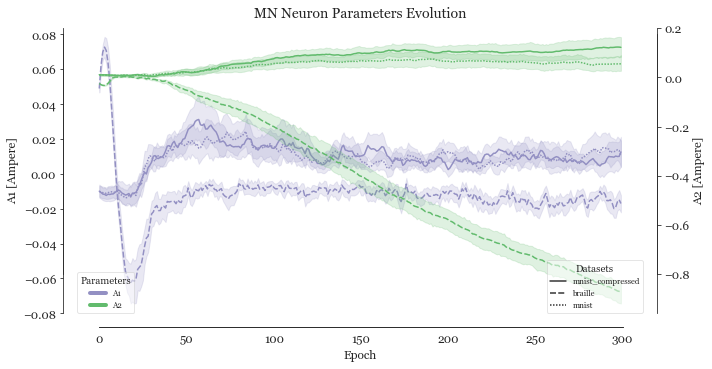

In [8]:
dfs_scalar_here = dfs_scalar[dfs_scalar['trained'] == True]#.loc[dfs_scalar['seed'] == 1]
# sns.FacetGrid(dfs_scalar_here, col='tag', hue="simulation", height=10, aspect=1.5,sharey='row',despine=True,legend_out=True,margin_titles=True).map(sns.lineplot, "step", "value")
# dfs_scalar_here = dfs_scalar_here.loc[dfs_scalar_here['simulation'] == 'braille']
## import line2d
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', family='georgia', size=SMALL_SIZE)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# fig1 = plt.figure(figsize=(20,5))
fig1,axis1 = plt.subplots(1,1,figsize=(10,5))

from matplotlib.lines import Line2D
p1 = Line2D([0], [0], color=sns.color_palette('Purples',10)[5], lw=4, label='A1')
p2 = Line2D([0], [0], color=sns.color_palette('Greens',10)[5], lw=4, label='A2')
# p4 = Line2D([0], [0], color='gray', lw=4, label='mnist_compressed',dashes=(2,2))
# p5 = Line2D([0], [0], color='gray', lw=4, label='braille',dashes=(3,0))
# p6 = Line2D([0], [0], color='gray', lw=4, label='mnist',dashes=(4,4))
# p0, = plt.plot([0], marker='None',
#            linestyle='None', label='dummy-tophead')
# p3, = plt.plot([0],  marker='None',
#            linestyle='None', label='dummy-empty')
sns_plot = sns.lineplot(data=dfs_scalar_here.query("tag == 'A1'"), x="step", y="value",style="simulation",legend=False,color=sns.color_palette('Purples',10)[5],ax=axis1,zorder=0)
axis2 = axis1.twinx()
sns_plot = sns.lineplot(data=dfs_scalar_here.query("tag == 'A2'"), x="step", y="value",style="simulation",legend=True,color=sns.color_palette('Greens',10)[5],ax=axis2,zorder=0)
## add title to legend
# for line in sns_plot.get_lines():
#     # lines.set_linestyle("--")
#     print(line.get_drawstyle())
axis1.set_ylabel('A1 [Ampere]')
axis2.set_ylabel('A2 [Ampere]')
##anchor legend outside to the left
# plt.legend(bbox_to_anchor=(-0.5, 1), loc=2, borderaxespad=0.)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
other_legend = plt.legend([p1,p2],['A1','A2'],title='Parameters',fancybox=True,shadow=False,loc = 'lower left',framealpha=0.5)

axis2.legend(title='Datasets',fancybox=True,shadow=False,loc = 'lower right',framealpha=0.5)
plt.gca().add_artist(other_legend)
# 
# axis2 = axis1.twinx()
# sns.lineplot(data=dfs_scalar_here.query("tag == 'A2'"), x="step", y="value", hue = 'tag', style="simulation",legend=True,palette='Greens',ax=axis2)
sns.despine(offset=10, trim=True,right=False)
# .despine(offset=10, trim=True,left=True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axis1.set_xlabel('Epoch')
# plt.ylabel('Value')
# plt.title('Parameter Evolution')
plt.tight_layout()
plt.title('MN Neuron Parameters Evolution')
plt.savefig('trained_params.pdf',dpi=300)
# plt.ylim(-5,6)

In [32]:
os.mkdir('MN_params_new')

In [35]:
import torch
dict_coll = []
dfs_scalar = dfs_scalar.loc[dfs_scalar['trained'] == True]
# fig1,axis1 = plt.subplots(2,1,figsize=(10,10))
for simulation in dfs_scalar['simulation'].unique():
    loc_s = dfs_scalar['simulation'] == simulation
    print('sim',simulation)
    for seed in range(20):
        print('seed',seed)
        loc_seed = dfs_scalar.loc[loc_s]['seed'] == seed
        for epoch in [0,98,197,296]:
            print('epoch',epoch)
            dict_sim = {}
            dict_param = {}

            loc_epoch = dfs_scalar.loc[loc_s & loc_seed]['step'] == epoch
            
            for tag in dfs_scalar.loc[loc_s]['tag'].unique():
                loc_t = dfs_scalar.loc[loc_s & loc_seed & loc_epoch]['tag'] == tag
                dict_param[tag] = float(dfs_scalar.loc[loc_t & loc_s & loc_seed & loc_epoch,'value'])
            dict_param['k1']=200
            dict_param['k2']=20
            l0 = MN_neuron_sp(
                1,
                {"a": 5, "A1": 0, "A2": 0},
                dt=(1 / 100.0),
                train=False,
                a=dict_param["a"],
                A1=dict_param["A1"],
                A2=dict_param["A2"],
                b=dict_param["b"],
                G=dict_param["G"],
                k1=dict_param['k1'],
                k2=dict_param['k2'],
                R1=dict_param["R1"],
                R2=dict_param["R2"],
                C=1,
            )
            if epoch == 296:
                json.dump(dict_param,open(f'MN_params_new/GR_{simulation}_w_'+str(seed)+'.json','w'))
            l0_spk = []
            l0_v = []
            l0_thr = []
            x_local = torch.zeros(1, 300)
            x_local[0, 100:] = torch.linspace(0, 10, 200)
            for t in range(x_local.shape[1]):
                _ = l0(x_local[:, t])
                # Get the spikes and voltages from the MN neuron encoder
                l0_spk.append(l0.state.spk)
                l0_v.append(l0.state.V)
                l0_thr.append(l0.state.Thr)
            dict_sim['t'] = (torch.arange(0,x_local.shape[1])*l0.dt).tolist()
            l0_spk = torch.stack(l0_spk, dim=1)
            dict_sim['l0_spk'] = l0_spk[0,:,0].tolist()
            l0_v = torch.stack(l0_v, dim=1)
            dict_sim['l0_v'] = l0_v[0,:,0].tolist()
            l0_thr = torch.stack(l0_thr, dim=1)
            dict_sim['l0_thr'] = l0_thr[0,:,0].tolist()
            for tag in dfs_scalar.loc[loc_s]['tag'].unique():
                loc_t = dfs_scalar.loc[loc_s & loc_seed & loc_epoch]['tag'] == tag
                dict_sim[tag] = [float(dfs_scalar.loc[loc_t & loc_s & loc_seed & loc_epoch,'value'])]*x_local.shape[1]
            dict_sim['seed'] = list([int(seed)]*x_local.shape[1])
            dict_sim['simulation'] = [simulation]*x_local.shape[1]
            dict_sim['epoch'] = list([int(epoch)]*x_local.shape[1])
            # axis1[0].plot(dict_sim['t'],dict_sim['l0_v'])
            # axis1[0].plot(dict_sim['t'],dict_sim['l0_thr'])
            # spikes = dict_sim['l0_spk'] == 1
            # axis1[1].scatter(dict_sim['t'][spikes],torch.ones_like(dict_sim['t'])[spikes],color='r',marker='.',s=10)
            # axis1[1].set_xlim(0,3)
            dict_coll.append(dict_sim)
print('we are here')

sim mnist_compressed
seed 0
epoch 0
epoch 98
epoch 197
epoch 296
seed 1
epoch 0
epoch 98
epoch 197
epoch 296
seed 2
epoch 0
epoch 98
epoch 197
epoch 296
seed 3
epoch 0
epoch 98
epoch 197
epoch 296
seed 4
epoch 0
epoch 98
epoch 197
epoch 296
seed 5
epoch 0
epoch 98
epoch 197
epoch 296
seed 6
epoch 0
epoch 98
epoch 197
epoch 296
seed 7
epoch 0
epoch 98
epoch 197
epoch 296
seed 8
epoch 0
epoch 98
epoch 197
epoch 296
seed 9
epoch 0
epoch 98
epoch 197
epoch 296
seed 10
epoch 0
epoch 98
epoch 197
epoch 296
seed 11
epoch 0
epoch 98
epoch 197
epoch 296
seed 12
epoch 0
epoch 98
epoch 197
epoch 296
seed 13
epoch 0
epoch 98
epoch 197
epoch 296
seed 14
epoch 0
epoch 98
epoch 197
epoch 296
seed 15
epoch 0
epoch 98
epoch 197
epoch 296
seed 16
epoch 0
epoch 98
epoch 197
epoch 296
seed 17
epoch 0
epoch 98
epoch 197
epoch 296
seed 18
epoch 0
epoch 98
epoch 197
epoch 296
seed 19
epoch 0
epoch 98
epoch 197
epoch 296
sim braille
seed 0
epoch 0
epoch 98
epoch 197
epoch 296
seed 1
epoch 0
epoch 98
epoch 197

In [36]:
dict_compressed = {}
for key in dict_coll[0].keys():
    dict_compressed[key] = []
for dict in dict_coll:
    for key in dict.keys():
        dict_compressed[key] += dict[key]

In [37]:
df = pd.DataFrame(dict_compressed)

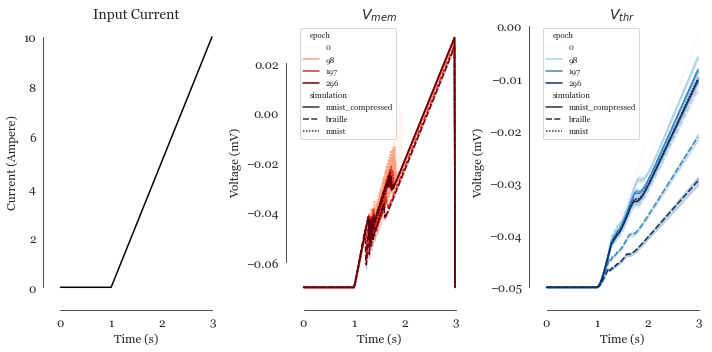

In [70]:
fig2,axis2 = plt.subplots(1,3,figsize=(10,5),sharey=False)
x_local = torch.zeros(1, 300)
x_local[0, 100:] = torch.linspace(0, 10, 200)
df_input = {}
df_input['t'] = (torch.arange(0,x_local.shape[1])*l0.dt).tolist()
df_input['input'] = x_local[0, :].tolist()
sns.lineplot(data=pd.DataFrame(df_input), x="t", y="input",legend=False,ax=axis2[0],color='k')
sim = df['simulation'][df['l0_spk'] == 1]
t = df['t'][df['l0_spk'] == 1] 
epochs = df['epoch'][df['l0_spk'] == 1]
seed = df['seed'][df['l0_spk'] == 1]
my_dict = {'sim':sim.tolist(),'t':t.tolist(),'epochs':epochs.tolist(),'seed':seed.tolist()}
spikes = pd.DataFrame(my_dict)
# sns.scatterplot(spikes.query('epochs==296'),x='t',y='seed',hue='sim',marker='|',ax=axis2[0])
sns.lineplot(data=df, x="t", y="l0_v", hue="epoch", style="simulation",palette='Reds',legend=True,ax=axis2[1])
sns.lineplot(data=df, x="t", y="l0_thr", hue="epoch", style="simulation",palette='Blues',legend=True,ax=axis2[2])
#remove spines
sns.despine(offset=10, trim=True)
#save figure
axis2[0].set_xlabel('Time (s)')
axis2[0].set_ylabel('Current (Ampere)')
axis2[0].set_title('Input Current')
axis2[1].set_xlabel('Time (s)')
axis2[1].set_ylabel('Voltage (mV)')
axis2[1].set_title('$V_{mem}$')
axis2[2].set_xlabel('Time (s)')
axis2[2].set_ylabel('Voltage (mV)')

# axis2[1].set_ylabel('Threshold (mV)')
axis2[2].set_title('$V_{thr}$')
plt.tight_layout()
plt.savefig('neuron_behaviour.pdf',dpi=300)
plt.show()

<AxesSubplot:xlabel='t', ylabel='l0_v'>

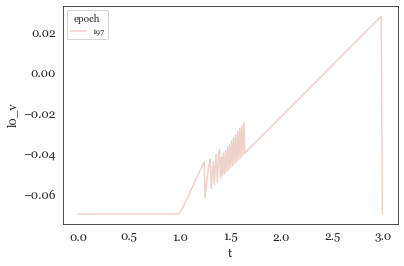

In [26]:
sns.lineplot(data=df.query('seed==0 & simulation == "braille" & epoch==197'), x="t", y="l0_v",hue='epoch',legend=True)



In [31]:
dfs_scalar_here.query('seed==0 & simulation == "braille" & step==197')
import json
my_dict = {}
for elements in dfs_scalar_here.query('seed==0 & simulation == "braille" & step==197').iterrows():
    my_dict[elements[1]['tag']] = elements[1]['value']
print(my_dict)
json.dump(my_dict,open('GR_Braille_w_0.json','w'))

{'A1': -0.0009264695108868182, 'A2': -0.6338659524917603, 'G': 46.74788284301758, 'R1': 0.48022520542144775, 'R2': -1.1800005435943604, 'a': 3.318552017211914, 'b': 11.684232711791992}


In [28]:
dfs_scalar_here

,step,tag,value,simulation,trained,seed,value_norm
0,0,A1,-0.016873,mnist_compressed,True,12,20.990913
1,1,A1,-0.017102,mnist_compressed,True,12,21.276197
2,2,A1,-0.017492,mnist_compressed,True,12,21.761152
3,3,A1,-0.016877,mnist_compressed,True,12,20.995322
4,4,A1,-0.017150,mnist_compressed,True,12,21.334999
...,...,...,...,...,...,...,...
405229,295,b,10.926833,mnist,True,19,0.998357
405230,296,b,10.932067,mnist,True,19,0.998835
405231,297,b,10.933944,mnist,True,19,0.999006
405232,298,b,10.941789,mnist,True,19,0.999723


<AxesSubplot:xlabel='t', ylabel='seed'>

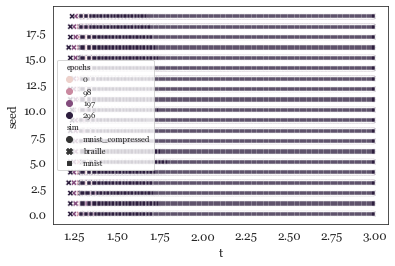

In [49]:
sns.FacetGrid(data=spikes,col='sim')scatterplot(data=spikes,x='t',y='seed',hue='epochs',style='sim',legend=True)

(1.0, 2.0)

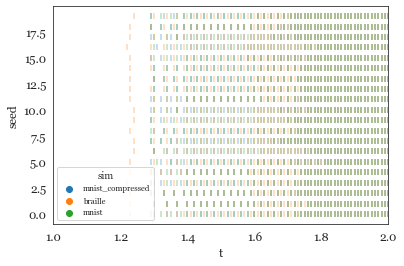

In [64]:
# sns.FacetGrid(data=spikes.query('epochs==296'),col='sim',legend_out=True).map(sns.scatterplot,'t','seed',hue='sim',marker='|')


plt.xlim(1,2)